In [1]:
import copy
import sys 
import numpy as np
import gym # gym version: 0.21.0
from collections import defaultdict

In [2]:
# Grid cell state and color mapping
EMPTY = BLACK = 0
WALL = GRAY = 1
AGENT = BLUE = 2
BOMB = RED = 3
GOAL = GREEN = 4

In [3]:
# RGB color value table
COLOR_MAP = {
    BLACK : [0.0, 0.0, 0.0],
    GRAY : [0.5, 0.5, 0.5],
    BLUE : [0.0, 0.0, 1.0],
    RED : [1.0, 0.0, 0.0],
    GREEN : [0.0, 1.0, 0.0]
}

In [4]:
# Action mapping
NOOP = 0
DOWN = 1
UP = 2
LEFT = 3
RIGHT= 4

In [5]:
class GridWorldEnv(gym.Env):
    def __init__(self, max_steps=100) -> None:
        """Initialize Gridworld

        Args:
            max_steps (int, optional): Max steps per episode. Defaults to 100.
        """
        # Observations
        self.grid_layout = """
        1 1 1 1 1 1 1 1
        1 2 0 0 0 0 0 1
        1 0 1 1 1 0 0 1
        1 0 1 0 1 0 0 1
        1 0 1 4 1 0 0 1
        1 0 3 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 1 1 1 1 1 1 1 
        """
        self.initial_grid_state = np.fromstring(self.grid_layout, dtype=int, sep=" ")
        self.initial_grid_state = self.initial_grid_state.reshape(8, 8)
        self.grid_state = copy.deepcopy(self.initial_grid_state)
        self.observation_space = gym.spaces.Box(low=0, high=6, shape=self.grid_state.shape)
        self.img_shape = [256, 256, 3]
        self.metadata = {"renfer.mode" : ["human"]}
        # Actions
        self.action_space = gym.spaces.Discrete(5)
        self.actios = [NOOP, DOWN, UP, LEFT, RIGHT]
        self.action_pos_dict = defaultdict(
            lambda : [0, 0],
            {
                NOOP: [0, 0],
                UP: [-1, 0],
                DOWN: [1, 0],
                LEFT: [0, -1],
                RIGHT: [0, 1],
            }
        )
        (self.agent_state, self.goal_state) = self.get_state()
        self.step_num = 0  # To keep track of number of steps
        self.max_steps = max_steps
        self.done = False
        self.info = {"status": "Live"}
        self.viewer = None
    def get_state(self):
        start_state = np.where(self.grid_state == AGENT)
        goal_state = np.where(self.grid_state == GOAL)

        start_or_gloal_not_found = not (start_state[0] and goal_state[0])
        if start_or_gloal_not_found:
            sys.exit(
                "Start and/or Goal state not present in the Gridworld. "
                "Check the Grid layout"
            )
        start_state = (start_state[0][0], start_state[1][0])
        goal_state = (goal_state[0][0], goal_state[1][0])
        return start_state, goal_state

    def step(self, action):
        """Return next observation, reward, done, info"""
        action = int(action)
        reward = 0.0

        next_state = (
            self.agent_state[0] + self.action_pos_dict[action][0],
            self.agent_state[1] + self.action_pos_dict[action][1]
        )
        next_state_invalid = ((next_state[0] < 0 or next_state[0] >= self.grid_state.shape[0]) or
                             (next_state[1] < 1 or next_state[1] >= self.grid_state.shape[1]))
        if next_state_invalid: 
            # Leave the agent state unchanged
            next_state = self.agent_state
            self.info["status"] = "Next state is invalid"

        next_agent_state = self.grid_state[next_state[0], next_state[1]]

        # Calculate Reward
        if next_agent_state == EMPTY:
            # Move agent from previous state to new state on the grid
            self.info["status"] = "Agent move to a new cell"
            self.grid_state[next_state[0], next_state[1]] = AGENT
            self.grid_state[self.agent_state[0], self.agent_state[1]] = EMPTY
            self.agent_state = copy.deepcopy(next_state)

        elif next_agent_state == WALL:
            self.info['status'] = "Agent bumped into a wall"
            reward = -1
        # Terminal state
        elif next_agent_state == GOAL:
            self.info['status'] = "Agent reached the GOAL"
            self.done = True
            reward = +1
        elif next_agent_state == BOMB:
            self.info['status'] = 'Agent stepped on a BOMB'
            self.done = True
            reward = -1
        # elif next_agent_state == AGENT:
        else:
            # NOOP or next state is invalid
            self.done = False

        self.step_num += 1

        # Check if max steps per episode has been reached
        if self.step_num > self.max_steps:
            self.done = True
            self.info['status'] = 'Max steps reached'

        if self.done:
            done = True
            terminal_state = copy.deepcopy(self.grid_state)
            terminal_info = copy.deepcopy(self.info)
            _ = self.reset()
            return (terminal_state, reward, done, terminal_info)

        return self.grid_state, reward, self.done, self.info   

    def reset(self):
        self.grid_state = copy.deepcopy(self.initial_grid_state)
        (self.agent_state, self.goal_state) = self.get_state()
        self.step_num = 0
        self.done = False
        self.info["status"] = "Live"
        return self.grid_state

    def gridarray_to_image(self, img_shape=None):
        if img_shape is None:
            img_shape = self.img_shape
        observation = np.random.randn(*img_shape) * 0.0
        scale_x = int(observation.shape[0] / self.grid_state.shape[0])
        scale_y = int(observation.shape[1] / self.grid_state.shape[1])
        for i in range(self.grid_state.shape[0]):
            for j in range(self.grid_state.shape[1]):
                for k in range(3):  # 3-channel RGB image
                    pixel_value = COLOR_MAP[self.grid_state[i, j]][k]
                    observation[
                        i * scale_x : (i + 1) * scale_x,
                        j * scale_y : (j + 1) * scale_y,
                        k,
                    ] = pixel_value
        return (255 * observation).astype(np.uint8)

    def render(self, mode="human", close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return
        img = self.gridarray_to_image()
        if mode == "rgb_array":
            return img
        elif mode == "human":
            from gym.envs.classic_control import rendering
            if self.viewer is None:
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img)

    def close(self):
        self.render(close=True)

    @staticmethod
    def get_action_meanings():
        return ["NOOP", "DOWN", "UP", "LEFT", "RIGHT"]

In [6]:
env = GridWorldEnv(max_steps=500)
obs = env.reset()
done = False
step_num = 1
# Run one episode
while not done:
    # Sample a random ac?tion from the action space
    action = env.action_space.sample()
    next_obs, reward, done, info = env.step(action)
    print(f"step#:{step_num} reward:{reward} done:{done} info:{info}")
    step_num += 1
    img = env.render(mode='rgb_array')
env.close()

step#:1 reward:0.0 done:False info:{'status': 'Agent move to a new cell'}
step#:2 reward:-1 done:False info:{'status': 'Agent bumped into a wall'}
step#:3 reward:0.0 done:False info:{'status': 'Agent move to a new cell'}
step#:4 reward:-1 done:False info:{'status': 'Agent bumped into a wall'}
step#:5 reward:0.0 done:False info:{'status': 'Agent move to a new cell'}
step#:6 reward:-1 done:False info:{'status': 'Agent bumped into a wall'}
step#:7 reward:-1 done:False info:{'status': 'Agent bumped into a wall'}
step#:8 reward:0.0 done:False info:{'status': 'Next state is invalid'}
step#:9 reward:-1 done:False info:{'status': 'Agent bumped into a wall'}
step#:10 reward:0.0 done:False info:{'status': 'Agent move to a new cell'}
step#:11 reward:0.0 done:False info:{'status': 'Agent move to a new cell'}
step#:12 reward:0.0 done:False info:{'status': 'Agent move to a new cell'}
step#:13 reward:0.0 done:False info:{'status': 'Agent move to a new cell'}
step#:14 reward:0.0 done:False info:{'stat

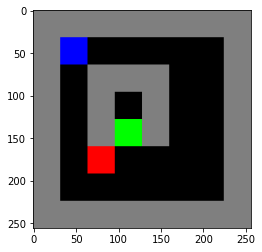

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img)